# Stitching of multiple Z-scans

Created on:  03.04.2022 <br />
Last update: 03.04.2022 <br />

## Configuration

In [1]:
import os
import numpy as np
# import dxchange
import tifffile
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

# from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian
# from skimage import measure, morphology
from skimage import transform

# from recon_utils import read_tiff_stack, plot_midplanes

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [2]:
%%html
<style>
table {float:left}
</style>

#### Input params

In [3]:
input_slice = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices/slice_0107.tif'

In [4]:
output_slice = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices_transform/slice_0030'

In [76]:
affine = [[0.999999763935778, 6.87115993353E-4, -0.035945611901949], [-6.87115993353E-4, 0.999999763935778, 3.804006345234143], [0, 0, 1]]

In [6]:
translate = [-0.36, 3.80]

#### Load one slice

In [14]:
slice = tifffile.imread(input_slice)

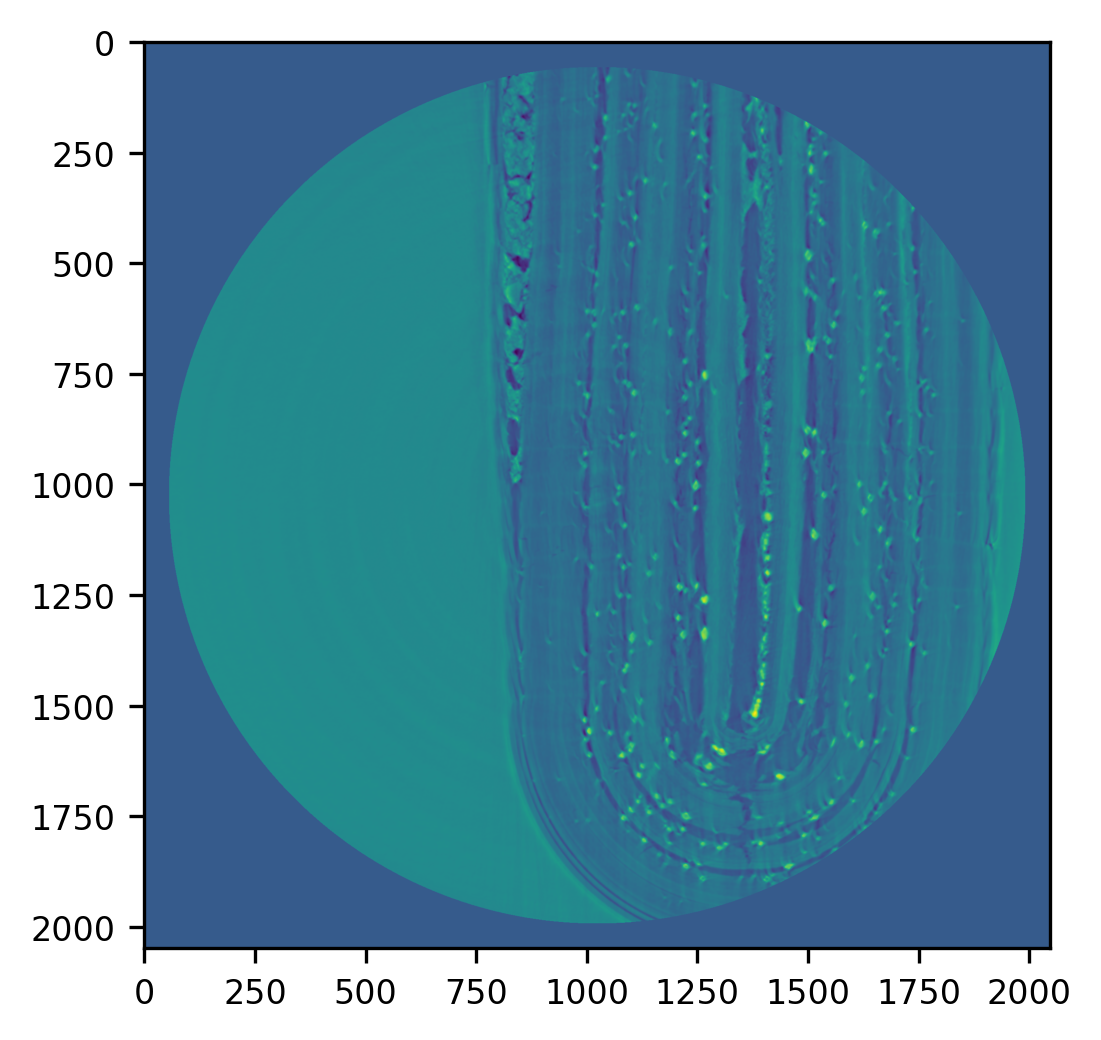

In [21]:
# Inspect slice
plt.imshow(slice)

#### Transform image

Prepare transform

In [17]:
tform = transform.AffineTransform(translation=translate)
print(tform.params)

[[ 1.   -0.   -0.36]
 [ 0.    1.    3.8 ]
 [ 0.    0.    1.  ]]


In [77]:
tform = transform.AffineTransform(matrix=np.array(affine))

In [78]:
print(tform.params)

[[ 9.99999764e-01  6.87115993e-04 -3.59456119e-02]
 [-6.87115993e-04  9.99999764e-01  3.80400635e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Apply the transform

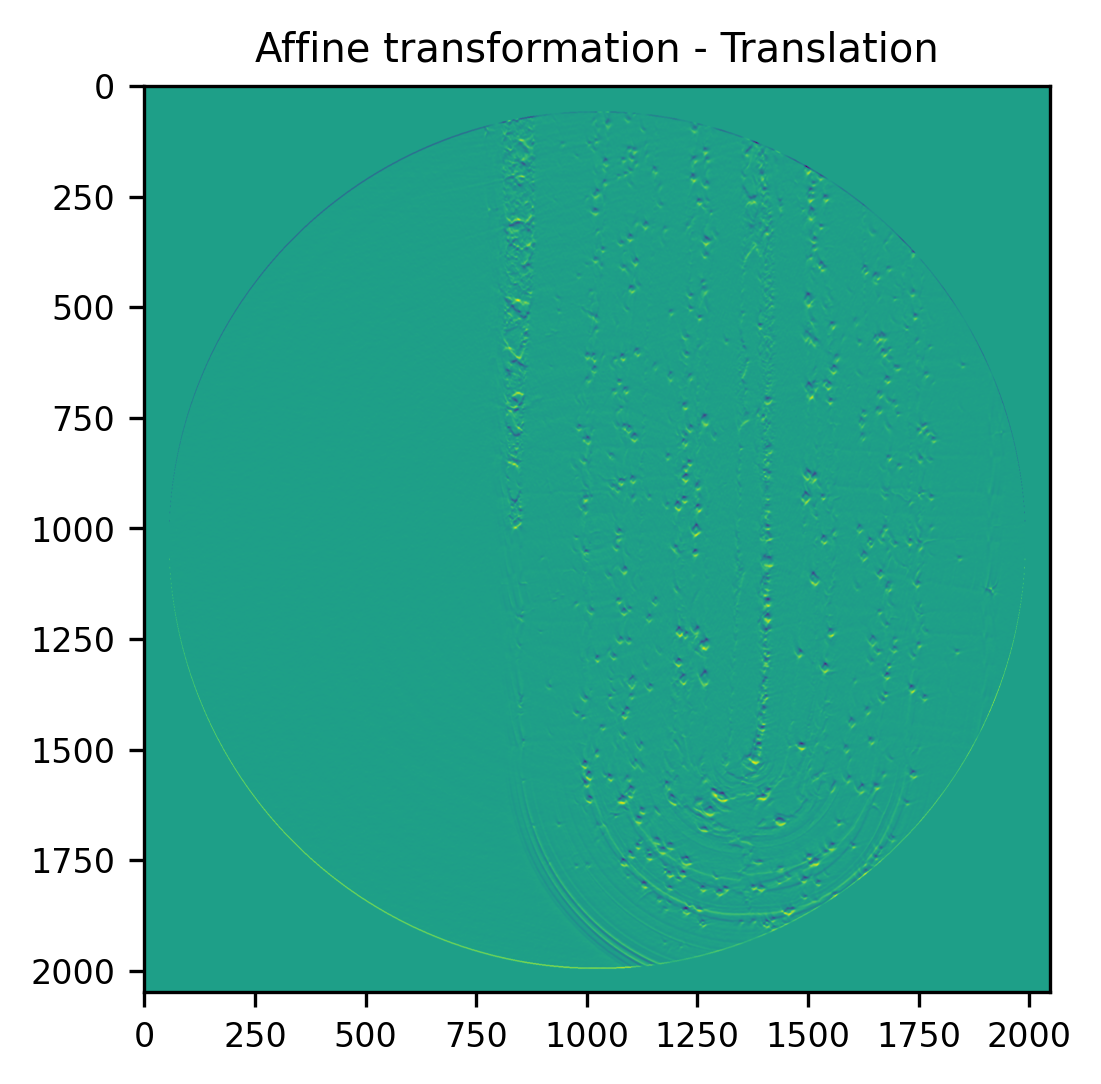

In [24]:
tf_img = transform.warp(slice, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Affine transformation - Translation')

Check

In [28]:
check_slice = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z1.9mm_corr_phrt/slices/slice_2047.tif'

In [29]:
check = tifffile.imread(check_slice)

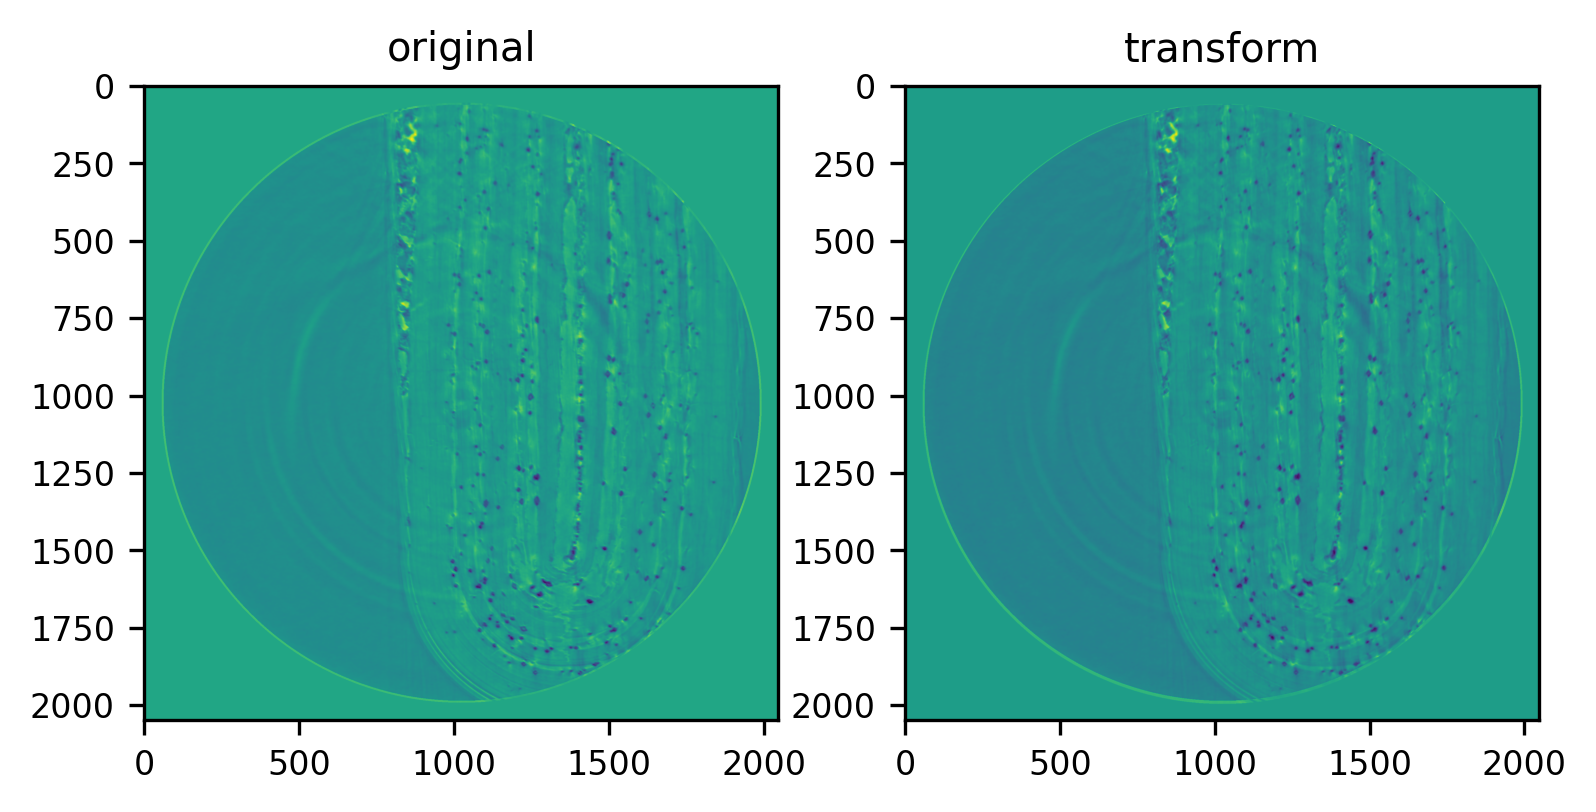

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(slice-check)
_ = ax1.set_title('original')
ax2.imshow(tf_img-check)
_ = ax2.set_title('transform')

Write output

In [33]:
tifffile.imwrite(output_slice, tf_img)

## Extending to stack

In [7]:
slices_in = [107, 109]

In [8]:
slice_out = 30

In [9]:
input_file = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices/slice_0000.tif'

In [10]:
output_slice = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices_transform/slice_0030.tif'

In [11]:
stack_files = [os.path.join(os.path.dirname(input_file), f) for f in os.listdir(os.path.dirname(input_file))
                     if os.path.isfile(os.path.join(os.path.dirname(input_file), f))]

In [12]:
stack_files.sort()

In [13]:
slice_ids = [int(filename[-8:-4]) for filename in stack_files]

In [14]:
slices_in_id = slice_ids.index(slices_in[0])

In [15]:
stack_files[slices_in_id:(slices_in_id+slices_in[1]-slices_in[0]+1):1]

['/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices/slice_0107.tif',
 '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices/slice_0108.tif',
 '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_Z0.0mm_corr_phrt_EL/slices/slice_0109.tif']

Prepare list of output filenames

In [38]:
stack_files_out = [output_slice[:-8] + str(slice_out+f).zfill(4) + '.tif' for f in range(0, len(stack_files[slices_in_id:(slices_in_id+slices_in[1]-slices_in[0]+1):1]))]

Check if files already exist

In [59]:
import logging
import os.path
overwrite = False

In [61]:
if any(os.path.exists(d) for d in stack_files_out):
    if overwrite:
        logging.warning('Files already exist and will be overwritten!')
    else:
        raise IOError('Files already exist. Run the code with --overwrite True.')

OSError: Files already exist. Run the code with --overwrite True.

In [18]:
tform_inverse = tform.inverse

In [21]:
count = 0
for filename in stack_files[slices_in_id:(slices_in_id+slices_in[1]-slices_in[0]+1):1]:
    data = tifffile.imread(filename)
    tf_data = transform.warp(data, tform_inverse)
    tifffile.imwrite(output_slice[:-8] + str(slice_out+count).zfill(4) + '.tif', tf_data)
    count = count + 1

In [68]:
affine = None
translate = None

In [70]:
any(transformation != None for transformation in [affine, translate])

False

In [79]:
import shutil